# 0.0 IMPORTS

## packages

In [218]:
import os, pickle, datetime, json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
import itertools
# from keras import models as ml
# from keras import layers as l
from category_encoders.target_encoder import TargetEncoder
from pandas_profiling import ProfileReport
from scipy import stats as ss
import sweetviz as sv
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\airbnb_prediction'

## 0.1 Helper Function

In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [116]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 0.2 Loading Data

In [117]:
df0 = pd.read_csv("data/train_users_2.csv")
df0.columns = df0.columns.str.lower()
df0.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [118]:
df_sessions = pd.read_csv( "data/sessions.csv" )
df_sessions.columns = df_sessions.columns.str.lower()
df_sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.00000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.00000


# 1.0 Data Description

In [119]:
df1 = df0.copy()

In [120]:
df_sessions1 = df_sessions.copy()

In [121]:
df1.shape

(213451, 16)

## 1.1 Check and Fill NAs

In [122]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.00000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.00000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [123]:
df1.isnull().sum()/len(df1)

id                        0.00000
date_account_created      0.00000
timestamp_first_active    0.00000
date_first_booking        0.58347
gender                    0.00000
age                       0.41223
signup_method             0.00000
signup_flow               0.00000
language                  0.00000
affiliate_channel         0.00000
affiliate_provider        0.00000
first_affiliate_tracked   0.02841
signup_app                0.00000
first_device_type         0.00000
first_browser             0.00000
country_destination       0.00000
dtype: float64

C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\3571433752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[df1['age']<65]['age'])


<AxesSubplot: xlabel='age', ylabel='Density'>

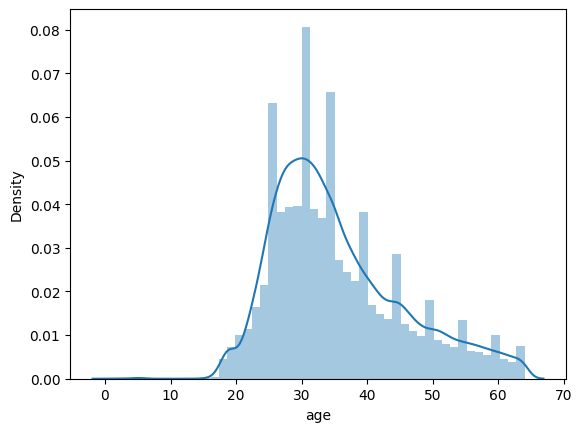

In [124]:
sns.distplot(df1[df1['age']<65]['age'])

In [125]:
# date first booking
for i in ["date_account_created", "date_first_booking"]:
    df1[i] = pd.to_datetime(df1[i])
date_first_booking_max = df1['date_first_booking'].max().strftime( "%Y-%m-%d" )
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1['age'] = df1['age'].fillna(df1['age'].mean())

print(df1['date_first_booking'].isnull().sum(), print(df1['age'].isnull().sum()))


# first_affiliate tracked
print( len(df1) )
df1 = df1[df1['first_affiliate_tracked'].notnull()]
print( len(df1) )

0
0 None
213451
207386


In [126]:
df1.isnull().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [127]:
df_sessions1.isnull().sum() / len(df_sessions1)

user_id         0.00326
action          0.00753
action_type     0.10657
action_detail   0.10657
device_type     0.00000
secs_elapsed    0.01287
dtype: float64

In [128]:
for i in df_sessions1.columns:
    df_sessions1 = df_sessions1[df_sessions1[i].notnull()]
    print( "tamanho:", len(df_sessions1))

tamanho: 10533241
tamanho: 10453761
tamanho: 9330804
tamanho: 9330804
tamanho: 9330804
tamanho: 9213930


## 1.2 Change Data Types

In [129]:
df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )


In [130]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [131]:

df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )
df1['age'] = df1['age'].astype(int)
print( df1.dtypes )

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object


In [132]:
print( len(df1) )
df1 = df1.dropna()
print( len(df1) )

207386
207386


## 1.3 Check Balanced Data

In [133]:
df1['country_destination'].value_counts( normalize=True )

NDF     0.57967
US      0.29446
other   0.04813
FR      0.02362
IT      0.01346
GB      0.01107
ES      0.01067
CA      0.00671
DE      0.00502
NL      0.00362
AU      0.00254
PT      0.00103
Name: country_destination, dtype: float64

## 1.4 Descriptive Analysis

In [134]:
df_sessions1.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.00000
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.00000
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.00000
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.00000


In [135]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [136]:
from scipy.stats import chi2_contingency



def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [137]:
cat_attributes_sessions = df_sessions1.select_dtypes(include='object')

In [138]:
# cat_attributes_list = df1.select_dtypes(include='object').drop( 'id', axis=1 ).columns.tolist()

# corr_dict = {}
# for i in range( len ( cat_attributes_list ) ):
#     corr_list = []
#     for j in range( len( cat_attributes_list ) ):
#         ref = cat_attributes_list[i]
#         feat = cat_attributes_list[j]
        
#         # correlation
#         corr = cramer_v( cat_attributes_list[ ref ], cat_attributes_list[ feat ] )
        
#         # append a list
#         corr_list.append( corr )
    
#     # appende a correlation list for each ref attributs
#     corr_dict[ ref ] = corr_list



# 2.0 Feature Engineering

In [139]:
df2 = df1.copy()

In [140]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Creature nem features

In [141]:
# days from frist active up to first booking

df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days)


# days from frist active upt to account created
df2['days_from_first_active_until_created'] = (df2['date_account_created'] - df2['first_active']).apply( lambda x: x.days)


# days from account created up to first booking
df2['days_from_accounted_created_until_first_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days)

################################ First active ##################################


# year of first active
df2['year_first_active'] = df2['first_active'].dt.year


# month of first active
df2['month_first_active'] = df2['first_active'].dt.month


# day of first active
df2['day_first_active'] = df2['first_active'].dt.day


# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.day_of_week


# week of year first active
df2['day_of_year_first_active'] = df2['first_active'].dt.day_of_year


######################## Booking #####################

# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year


# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month


# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day


# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.day_of_week


# week of year first booking
df2['day_of_year_first_booking'] = df2['date_first_booking'].dt.year

#=================================== First Account Created ==============================
# year of first account_created
df2['year_first_account_created'] = df2['date_account_created'].dt.year


# month of first account_created
df2['month_first_account_created'] = df2['date_account_created'].dt.month


# day of first account_created
df2['day_first_account_created'] = df2['date_account_created'].dt.day


# day of week first account_created
df2['day_of_week_first_account_created'] = df2['date_account_created'].dt.day_of_week


# week of year first account_created
df2['day_of_year_first_account_created'] = df2['date_account_created'].dt.day_of_year

In [142]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_booking,days_from_first_active_until_created,days_from_accounted_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,day_of_year_first_active,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,day_of_year_first_booking,year_first_account_created,month_first_account_created,day_first_account_created,day_of_week_first_account_created,day_of_year_first_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,2293,466,2293,2009,3,19,3,78,2015,6,29,0,2015,2010,6,28,0,179
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,2228,732,2228,2009,5,23,5,143,2015,6,29,0,2015,2011,5,25,2,145
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,419,476,419,2009,6,9,1,160,2010,8,2,0,2010,2010,9,28,1,271
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,1043,765,1043,2009,10,31,5,304,2012,9,8,5,2012,2011,12,5,0,339
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,72,280,72,2009,12,8,1,342,2010,2,18,3,2010,2010,9,14,1,257


In [143]:
df2.shape

(207386, 35)

# 3.0 Data Filtering

In [144]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [145]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[ (df3['age']>15) & (df3['age']<100) ]

# secs_elapsed - There is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed']>0 ]

# 4.0 EDA

In [146]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [147]:
profile = ProfileReport(df4, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [148]:
# remove columns with a lot of zeros ( >90%)

# aux0 = (df4==0).sum(axis=0)
# cols_zeros = (aux0/len(df4)).sort_values(ascending=False)
# cols_zeros = cols_zeros[cols_zeros>0.9]
# print( cols_zeros )
# print( df4.shape )
# df4 = df4.drop(cols_zeros.index, axis=1)
# print( df4.shape )

In [149]:
# remove columns with almost no information ( very low cardinality )

low_card_cols = []

for i in df4.columns:
    if df4[i].value_counts(normalize=True).max()>0.85:
        low_card_cols.append(i)

print( low_card_cols )

print( df4.shape )
df4 = df4.drop( low_card_cols , axis=1 )
print( df4.shape )

['language', 'signup_app', 'days_from_first_active_until_created']
(205019, 35)
(205019, 32)


## 4.2 Bivariate Analysis


columns to drop: ['days_from_accounted_created_until_first_booking', 'day_of_year_first_active', 'day_of_year_first_booking', 'year_first_account_created', 'month_first_account_created', 'day_first_account_created', 'day_of_week_first_account_created', 'day_of_year_first_account_created']


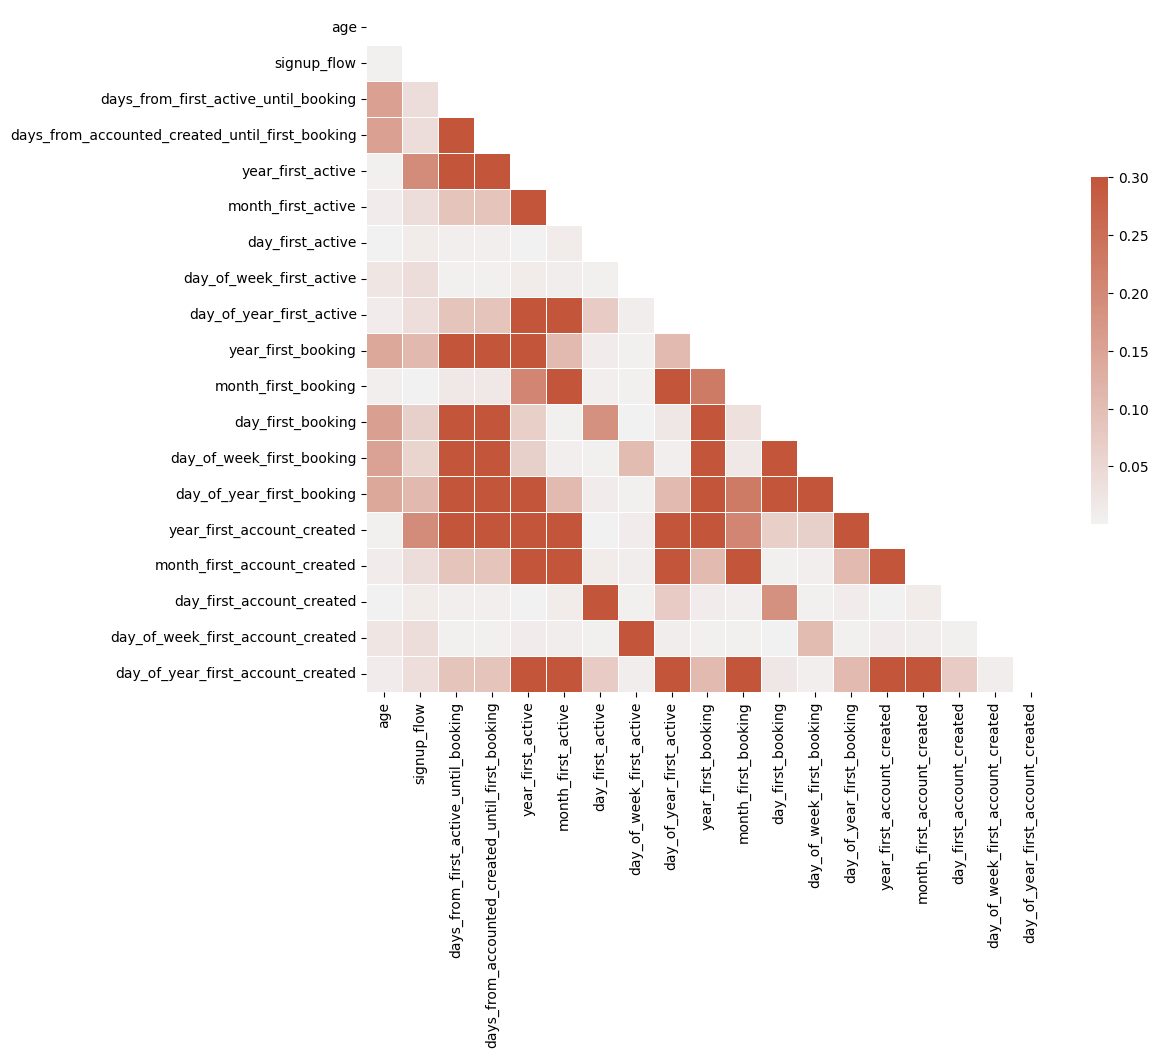

In [150]:

# Compute the correlation matrix
corr = df4.select_dtypes(exclude=["object","datetime64[ns]"]).corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features 
print( f"columns to drop: {to_drop}")


In [151]:
# only "booking" columns will be tested

to_drop2 = [x for x in to_drop if not re.search(r'first_booking', x)]
print(to_drop2)

['day_of_year_first_active', 'year_first_account_created', 'month_first_account_created', 'day_first_account_created', 'day_of_week_first_account_created', 'day_of_year_first_account_created']


<AxesSubplot: >

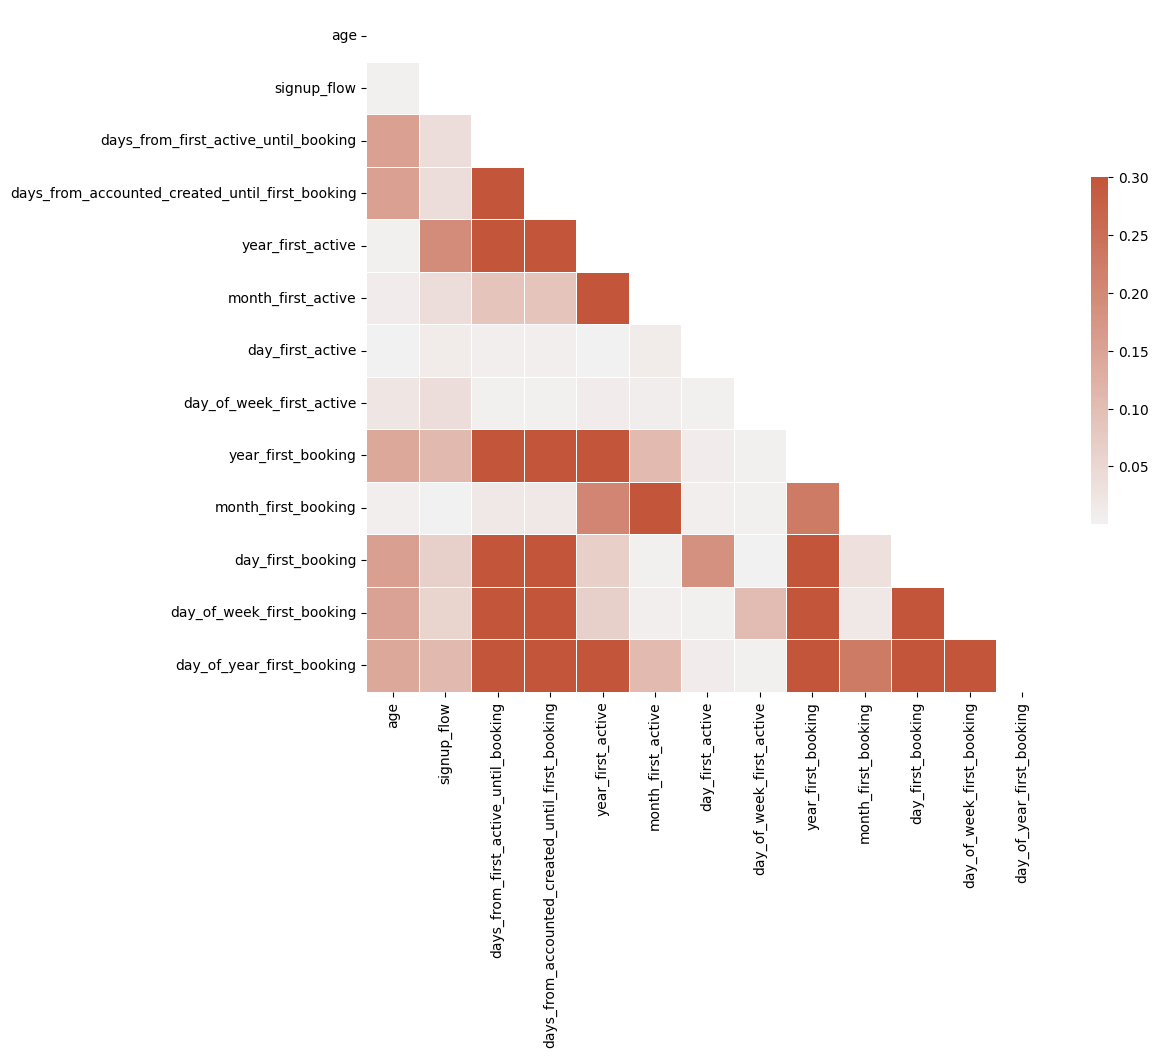

In [152]:
df4 = df4.drop(to_drop2, axis=1)
# Compute the correlation matrix
corr2 = df4.select_dtypes(exclude=["object","datetime64[ns]"]).corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr2, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\kosmo\AppData\Local\Temp\ipykernel_18852\4156658604.py:13: RuntimeWar

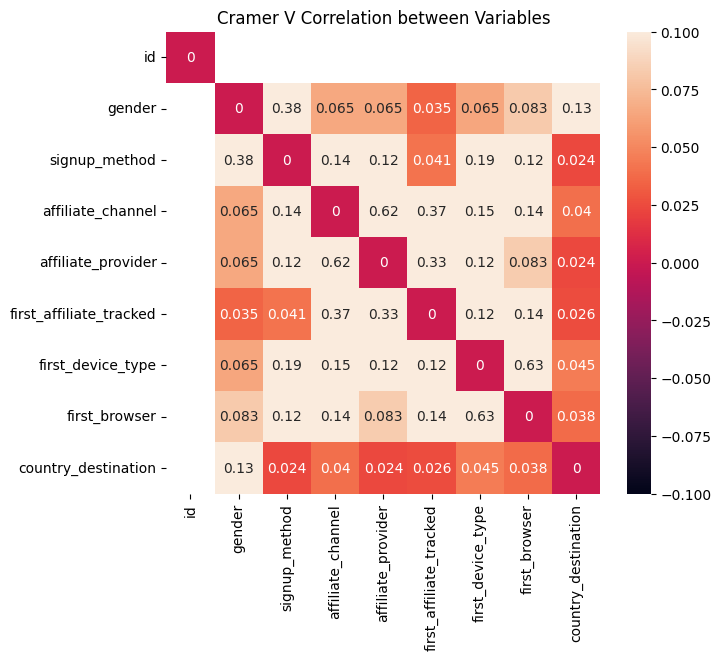

In [153]:



cols = df4.select_dtypes(include='object').columns.tolist()
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df4[col1], df4[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

In [154]:
# affiliate channel is highly correlated with affiliate provider, the one with less cardinality will be kept ( In general, the same information with less cardinality is better than high's)

col_remove1= df4[['affiliate_channel', 'affiliate_provider']].nunique().idxmin()
print( col_remove1 )
df4 = df4.drop( col_remove1, axis=1 )



# affiliate first device type is highly correlated with first_browser ( In general, the same information with less cardinality is better than high's)

col_remove2 = df4[['first_device_type', 'first_browser']].nunique().idxmin()
print( col_remove2 )
df4 = df4.drop( col_remove2 , axis=1 )



affiliate_channel
first_device_type


## 4.3 Multivariate analysis - Hypoteses Validation

<AxesSubplot: xlabel='country_destination'>

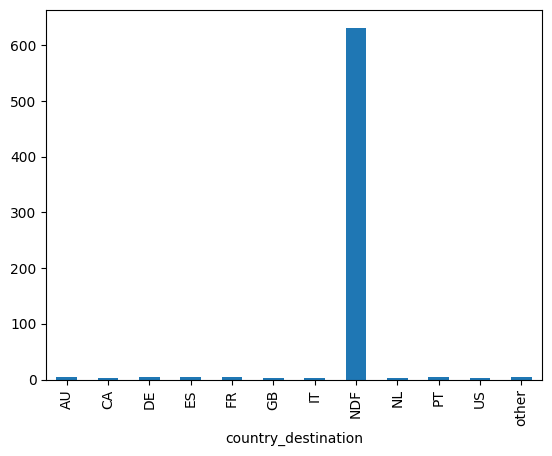

In [155]:
df4.groupby("country_destination")["days_from_first_active_until_booking"].median().plot(kind='bar')

<AxesSubplot: xlabel='country_destination'>

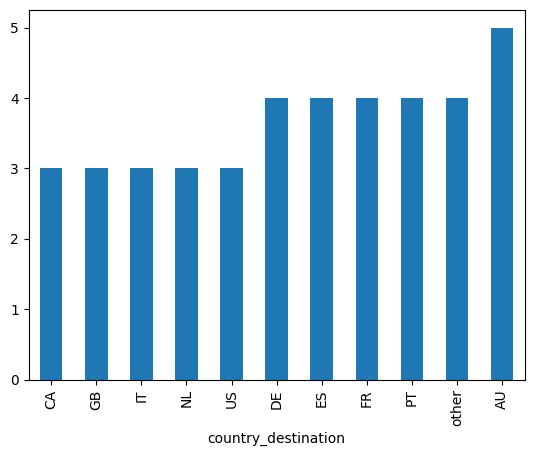

In [156]:
df4[df4["country_destination"]!="NDF"].groupby("country_destination")["days_from_first_active_until_booking"].median().sort_values().plot(kind='bar')

<AxesSubplot: xlabel='year_first_booking'>

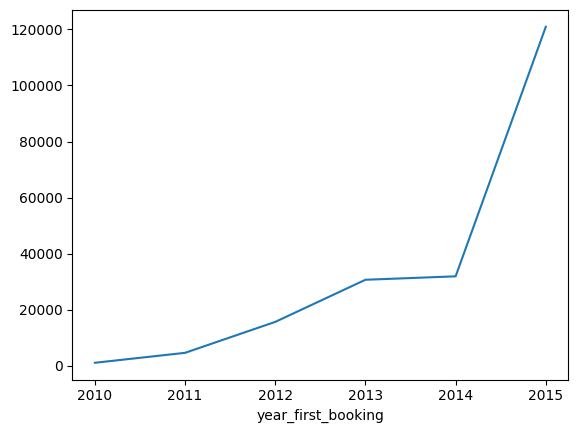

In [158]:
df4.groupby("year_first_booking")['id'].count().sort_index().plot()

<AxesSubplot: >

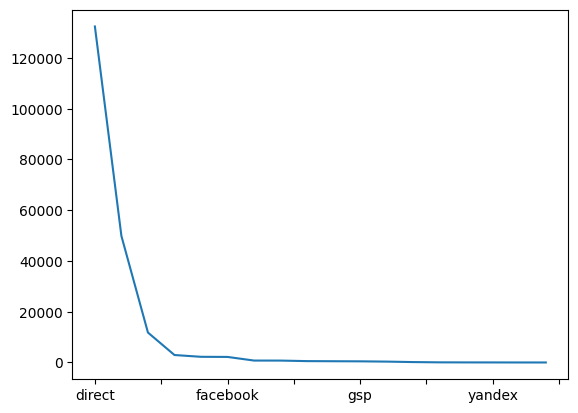

In [159]:
df4["affiliate_provider"].value_counts().plot()

# 5.0 Data Prep

In [259]:
df5 = df4.copy()
for i in ['signup_flow']:
    df5[i] = df5[i].astype("category")

In [260]:
numeric_cols = df5.select_dtypes(exclude=['object', 'datetime64[ns]', "category"]).columns
numeric_cols

Index(['age', 'days_from_first_active_until_booking',
       'days_from_accounted_created_until_first_booking', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'year_first_booking', 'month_first_booking', 'day_first_booking',
       'day_of_week_first_booking', 'day_of_year_first_booking'],
      dtype='object')

## 5.1 Rescaling

In [261]:
# MinMax
for i in numeric_cols:
    mms = MinMaxScaler()
    mms.fit_transform( df5[[i]])
    pickle.dump(mms, open(f'{mms.__class__.__name__}_{i}.pkl', 'wb'))

## 5.2 Encoding

In [262]:
cols_te = df5.drop(["country_destination","id"], axis=1).select_dtypes(include=['object','category']).columns.tolist()
cols_te

['gender',
 'signup_method',
 'signup_flow',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser']

In [263]:
dic_countries = {}
for n,v in enumerate(df5['country_destination'].unique()):
    dic_countries[n]= v
dic_countries

{0: 'NDF',
 1: 'US',
 2: 'other',
 3: 'CA',
 4: 'FR',
 5: 'ES',
 6: 'GB',
 7: 'IT',
 8: 'PT',
 9: 'NL',
 10: 'DE',
 11: 'AU'}

In [264]:
os.makedirs( os.getcwd()+"\preprocessors", exist_ok=True)
for i in cols_te:
    te = TargetEncoder()
    te.fit_transform( df5[i], df5['country_destination'].map(dic_countries) )
    pickle.dump(te, open(f'{te.__class__.__name__}_{i}.pkl', 'wb'))

## 5.3 Nature Transformation

In [265]:
# day of week
for i in [ 'month_first_active','day_first_active', 'day_of_week_first_active','month_first_booking', 'day_first_booking','day_of_week_first_booking', 'day_of_year_first_booking']:
    T=df5[i].nunique()
    df5[f'{i}_sin'] = df5[i].apply( lambda x: np.sin( x * ( 2. * np.pi/T) ) ) 
    df5[f'{i}_cos'] = df5[i].apply( lambda x: np.cos( x * ( 2. * np.pi/T) ) ) 

# 6.0 Feature Selection

In [266]:
df6 = df5.copy()

In [267]:
cols_drop = ['date_account_created', 'timestamp_first_active', "date_first_booking", "first_active","date_first_booking",]
df6 = df6.drop( cols_drop , axis=1)

# 7.0 Machine Learning Model

In [268]:
df7 = df6.copy()

In [269]:
X = df7.drop( ["country_destination","id"] , axis=1 )
y = df7['country_destination'].copy()

In [270]:
Xtrain, Xtest, ytrain, ytest = train_test_split( X, y, test_size = 0.2, random_state=42 )

## 7.1 Baseline Model

In [271]:
country_list = np.sort(y.unique())
country_list

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [272]:
weights_country = y.value_counts(normalize=True).sort_index()
weights_country

AU      0.00253
CA      0.00668
DE      0.00499
ES      0.01065
FR      0.02361
GB      0.01102
IT      0.01337
NDF     0.58135
NL      0.00360
PT      0.00103
US      0.29329
other   0.04788
Name: country_destination, dtype: float64

In [273]:
yhat_random = random.choices( population=country_list, weights=weights_country ,k=len(Xtest))

In [274]:
# accuracy

acc_nn = accuracy_score(ytest, yhat_random)

bacc_nn = balanced_accuracy_score(ytest, yhat_random)

kappa_nn = cohen_kappa_score(ytest, yhat_random)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)


0.42430006828602085 
 0.08102371330244924 
 -0.0015637472897356286


Confusion matrix, without normalization
[[13777  6993  1140   176   586   288   313   335    16    70   119    70]
 [ 6912  3488   579    79   295   123   115   168    13    37    62    30]
 [ 1156   595   102    15    51    25    25    33     1     7    14     8]
 [  163    92    15     1     6     1     6     1     1     1     0     0]
 [  541   287    49     4    17    11    15    17     1     2     7     1]
 [  234   132    23     4     8     5     3    11     0     0     1     0]
 [  271   140    22     3    12     5     3     2     0     2     2     0]
 [  322   147    21     5    19     6     6     4     0     1     4     1]
 [   24    13     2     0     1     0     0     0     0     0     1     0]
 [  100    46     5     2     2     2     3     2     0     0     1     2]
 [  117    56    12     1     5     3     3     3     0     0     1     0]
 [   80    34     1     2     2     0     2     2     0     0     0     0]]


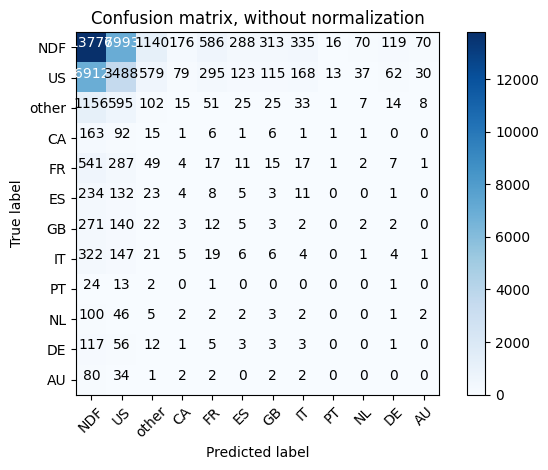

In [275]:
cnf_matrix = confusion_matrix(ytest, yhat_random,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

## 7.2 Neural Network Model

In [ ]:

ohe = OneHotEncoder()
ytrain_nn = ohe.fit_transform( ytrain.values.reshape( -1, 1 ) ).toarray()


In [ ]:
model = ml.Sequential()
model.add( l.Dense( 256, input_dim = Xtrain.shape[1], activation = "relu" ) )
model.add( l.Dense( 12, activation="softmax") )

#model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

#train model
model.fit( Xtrain, ytrain_nn, epochs=100 )

Epoch 1/100
5165/5165 [==============================] - 15s 2ms/step - loss: 9.3327 - accuracy: 0.7821
Epoch 2/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.7826 - accuracy: 0.8406
Epoch 3/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5313 - accuracy: 0.8670
Epoch 4/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5240 - accuracy: 0.8683
Epoch 5/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5200 - accuracy: 0.8687
Epoch 6/100
5165/5165 [==============================] - 11s 2ms/step - loss: 0.5193 - accuracy: 0.8688
Epoch 7/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5147 - accuracy: 0.8695
Epoch 8/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5140 - accuracy: 0.8697
Epoch 9/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5075 - accuracy: 0.8700
Epoch 10/100
5165/5165 [==============================] - 10s 2m

KeyboardInterrupt: 

# 6.0 NN Performance

In [ ]:
# prediction
pred_nn = model.predict( Xtest )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
ytest_nn = ytest.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

427/427 [==============================] - 1s 3ms/step


In [ ]:
# accuracy

acc_nn = accuracy_score(ytest_nn, yhat_nn)

bacc_nn = balanced_accuracy_score(ytest_nn, yhat_nn)

kappa_nn = cohen_kappa_score(ytest_nn, yhat_nn)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)

0.7098643197653098 
 0.09148376904356637 
 0.003565012830887282


In [ ]:
print(classification_report(ytest_nn, yhat_nn))

p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        90
          CA       0.00      0.00      0.00       210
          DE       0.00      0.00      0.00       176
          ES       0.00      0.00      0.00       344
          FR       0.50      0.00      0.01       742
          GB       0.00      0.00      0.00       356
          IT       0.25      0.00      0.00       399
          NL       0.00      0.00      0.00       107
          PT       0.00      0.00      0.00        26
          US       0.71      1.00      0.83      9704
       other       0.29      0.00      0.01      1481

    accuracy                           0.71     13635
   macro avg       0.16      0.09      0.08     13635
weighted avg       0.57      0.71      0.59     13635



p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[9669   16    2    2    2    2    8    1    1    0    1]
 [1470    7    0    0    0    0    3    0    1    0    0]
 [ 210    0    0    0    0    0    0    0    0    0    0]
 [ 737    0    0    2    0    0    2    1    0    0    0]
 [ 395    1    0    0    1    0    2    0    0    0    0]
 [ 341    0    0    0    1    0    1    0    1    0    0]
 [ 355    0    0    0    0    1    0    0    0    0    0]
 [ 107    0    0    0    0    0    0    0    0    0    0]
 [ 176    0    0    0    0    0    0    0    0    0    0]
 [  89    0    0    0    0    0    1    0    0    0    0]
 [  26    0    0    0    0    0    0    0    0    0    0]]


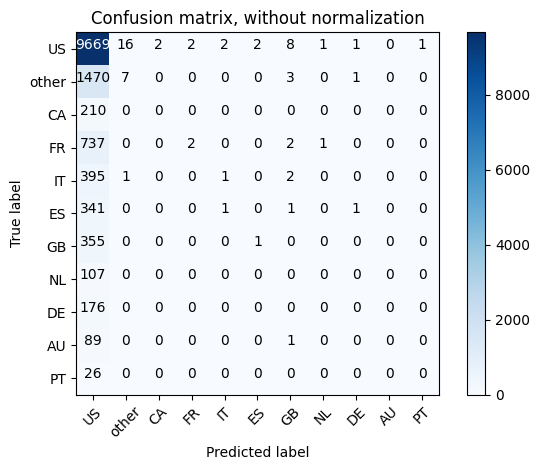

In [ ]:
cnf_matrix = confusion_matrix(ytest_nn, yhat_nn,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

In [ ]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( Xtrain, ytrain ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    Xtrain_fold = Xtrain.iloc[train_ix]
    ytrain_fold = ytrain.iloc[train_ix]
    
    x_val_fold = Xtrain.iloc[val_ix]
    y_val_fold = ytrain.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    ytrain_fold_nn = ohe.fit_transform( ytrain_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=Xtrain.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( Xtrain_fold, ytrain_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 2/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 3/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 4/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 5/5
341/341 [==============================] - 0s 1ms/step


In [ ]:
print( np.mean( balanced_acc_list), np.std( balanced_acc_list))
print( np.mean( kappa_acc_list), np.std( kappa_acc_list))

0.09169763963827852 0.0008134784013867776
0.0043365562461069596 0.0029099456969170216
